In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.append('../../code/')
sys.path.append('/Users/ssulheim/git/mwf_gems/code/python')
import leakage_reframed
import ng_utils
import leakage
import reframed
import scipy

# C glutamicum

In [3]:
exometabolites_folder = Path("../../data/c_glutamicum/")
organism = 'c_glutamicum'
fn_OD = exometabolites_folder / "{0}_OD.csv".format(organism)

In [4]:
gDW_per_OD = 0.32

In [5]:
concentrations, concentrations_std = leakage.get_concentrations(exometabolites_folder, 'c_glutamicum')

In [6]:
df_OD = pd.read_csv(fn_OD, index_col=0)
df_OD.fillna(df_OD['OD std'].mean())

,OD mean,OD std
Time,,
0,0.291000,3.657989
11,2.460000,0.040000
12,3.366667,0.070946
13,4.123333,0.075719
14,5.316667,0.049329
15,8.813333,0.147422
16,14.000000,0.200000
17,15.866667,0.208167
18,19.533333,0.503322


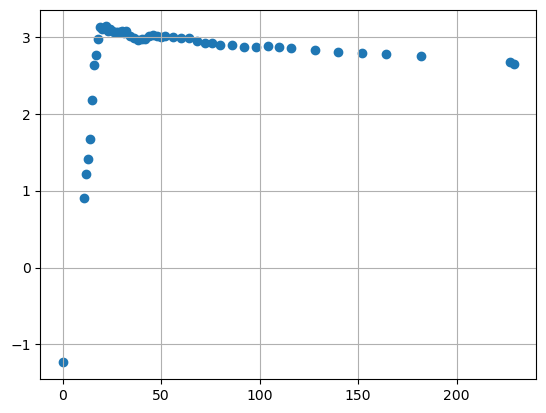

In [14]:
plt.scatter(df_OD.index, np.log(df_OD['OD mean']))
plt.grid()

# Estimate max glucose uptake rate
Answer = -2.5 mmol/gDW/h

In [10]:
fn_glucose = exometabolites_folder / "{0}_glucose.csv".format(organism)

df_glucose = pd.read_csv(fn_glucose, index_col=0)
# df_glucose.loc[0,:]=[20,0] # From paper (in g/L)

In [67]:
cum_OD = np.zeros(53)*np.nan
OD_values = df_OD['OD mean'].values
timepoints = df_OD.index
for i in range(9):
    cum_OD[i] = scipy.integrate.trapezoid(y = OD_values[:i+1], x = timepoints[:i+1])

In [35]:
mu = (np.log(OD_values)[9]-np.log(OD_values)[1])/(timepoints[9]-timepoints[1])

In [61]:
growth_fun = lambda t: OD_values[1]*np.exp(mu*(t-11))

In [71]:
timepoints

Index([  0,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
        24,  25,  26,  27,  28,  29,  30,  31,  32,  34,  36,  38,  40,  42,
        44,  46,  48,  50,  52,  56,  60,  64,  68,  72,  76,  80,  86,  92,
        98, 104, 110, 116, 128, 140, 152, 164, 182, 227, 229],
      dtype='int64', name='Time')

In [68]:
df_OD['Cum OD'] = cum_OD
df_OD['Cum OD gDW'] = df_OD['Cum OD']*gDW_per_OD
df_glucose['Glucose mM'] = df_glucose['Glucose mean']/180.18*1000

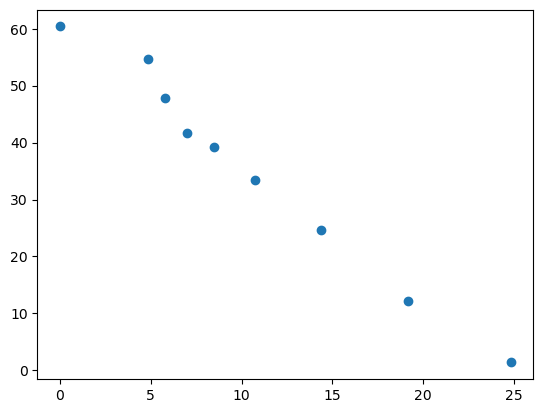

In [74]:
plt.scatter(df_OD['Cum OD gDW'], df_glucose['Glucose mM'])

In [76]:
np.polyfit(df_OD['Cum OD gDW'][:9], df_glucose['Glucose mM'][:9], 1)

array([-2.50038   , 61.48551647])

## Mapping

In [117]:
mapping_df = pd.read_csv('../../data/id_mapping.csv', index_col=0)
# mapping_df.index = [x.strip('\t').replace(" MS", "") for x in mapping_df.index]
met_abrv_to_id = mapping_df['Cglutamicum metabolite'].to_dict()
met_abrv_to_name = mapping_df['Metabolite name'].to_dict()


# Estimate rates

In [118]:
timepoints[:9]

Index([0, 11, 12, 13, 14, 15, 16, 17, 18], dtype='int64', name='Time')

In [119]:
x = np.cumsum(df_OD['OD mean'])*gDW_per_OD

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


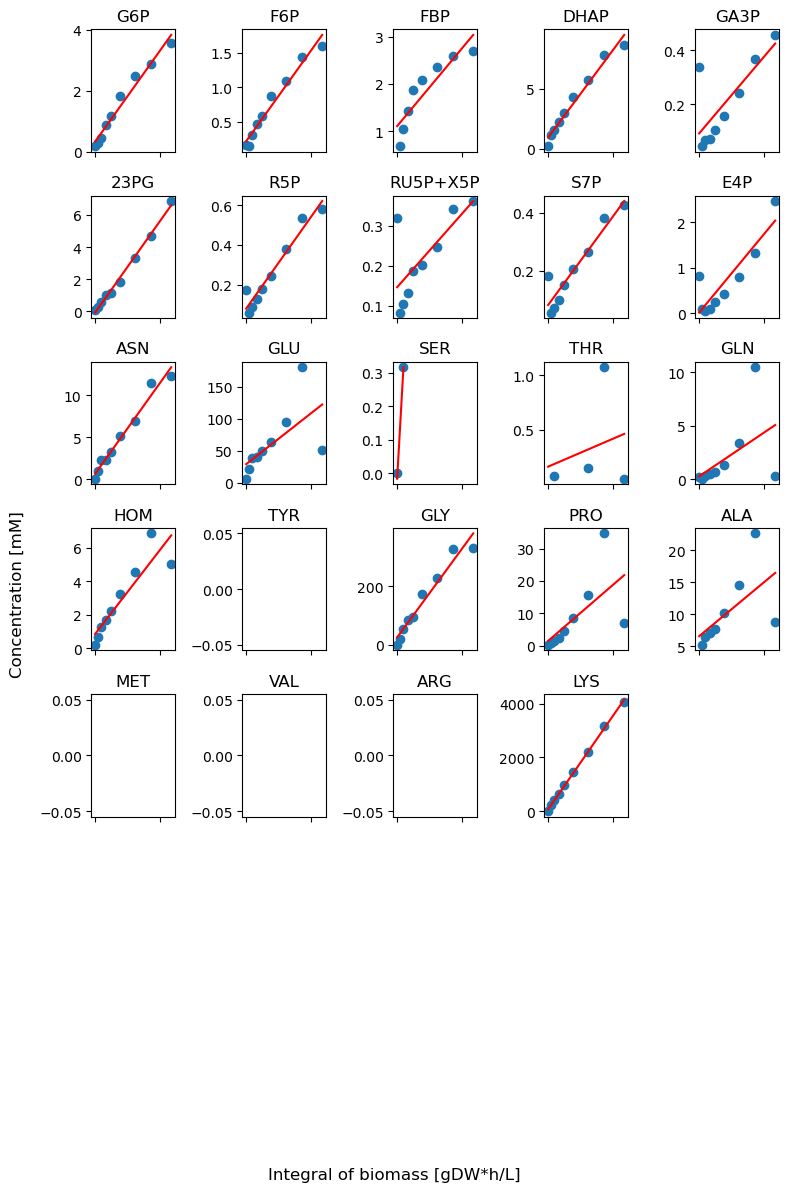

In [120]:
rate_dict = {}
fig, axes = plt.subplots(7,5, figsize = (8, 12), sharex = True)
axes = axes.flatten()
fun = lambda x, a ,b: x*a+b
for i,c in enumerate(concentrations.columns):
    conc = concentrations[c]
    conc[conc==0] = np.nan
    nan_idx = ~np.isnan(conc)
    time_idx = x.index < 19
    if np.sum(nan_idx&time_idx) == 1:
        conc[0] = 0
        nan_idx[0] = True
        
    # print(conc[nan_idx&time_idx])
    rate_conc = conc[nan_idx&time_idx]
    selection = np.ones(len(conc)).astype(bool)
    # if (7 in rate_conc.index) and (8 in rate_conc.index):
    #     if rate_conc[8] < rate_conc[7]:
    #         selection[8] = False
    #         if rate_conc[6] < rate_conc[7]:
    #             selection[7] = False
    # print(c)
    # print(conc[nan_idx&time_idx])
    if len(conc[nan_idx&time_idx&selection]) >1:
        fit, cov, _,_,_ = scipy.optimize.curve_fit(fun, x[nan_idx&time_idx&selection],
                                                   conc[nan_idx&time_idx&selection],
                                                   full_output=True)
        rate_dict[c] = fit[0]
    else:
        rate_dict[c] = np.nan

    # print(fit)
    x_fit = np.linspace(0, x[nan_idx&time_idx].max(), 3)
    y_fit = fun(x_fit, *fit)
    ax = axes[i]
    # ax.scatter(x, conc)
    ax.scatter(x[nan_idx&time_idx], conc[nan_idx&time_idx])
    ax.plot(x_fit, y_fit, 'r')
    ax.set_title(c, )

i +=1
# print(i)
while i<(7*5):
    axes[i].set_visible(False)
    i+=1

fig.supxlabel('Integral of biomass [gDW*h/L]')
fig.supylabel('Concentration [mM]')

plt.tight_layout()
plt.show()


# Get model

In [121]:
model_ez = reframed.load_cbmodel('../../models/c_glutamicum/smoment_iCW773.xml')
model_ez.solver = 'gurobi'

In [122]:
solution = reframed.FBA(model_ez)
solution.show_values('EX')

R_EX_ca2_e   -0.0146654
R_EX_co2_e    10.0349
R_EX_cobalt2_e -7.08926e-05
R_EX_cu2_e   -0.00199691
R_EX_fe2_e   -0.0409159
R_EX_glc_e   -4.67
R_EX_h_e      3.35021
R_EX_h2o_e    19.5406
R_EX_k_e     -0.549947
R_EX_mg2_e   -0.024442
R_EX_mn2_e   -0.00194803
R_EX_nh4_e   -3.75795
R_EX_ni2_e   -0.000909257
R_EX_o2_e    -8.78033
R_EX_pi_e    -0.215743
R_EX_so4_e   -0.0696158
R_EX_xan_e    0.0696769
R_EX_zn2_e   -0.000960563
R_EX_biomass  0.434189
R_EX_BIOTIN  -1.03175e-06
R_EX_cl      -0.0146654


In [124]:
measured_metabolites = []
for bigg_id in met_abrv_to_id.values():
    if not isinstance(bigg_id, str):
        continue
    m_ids = bigg_id.split(', ')
    for m_id in m_ids:
        if f'M_{m_id}_c' in model_ez.metabolites:
            measured_metabolites.append(f'M_{m_id}_c')

# Shadow prices

In [125]:
shadow_prices = leakage_reframed.estimate_shadow_prices(model_ez, constraints={'R_EX_glc_e': (-2.5,0)}, metabolites = measured_metabolites)

In [126]:
measured_metabolites

['M_g6p_c',
 'M_f6p_c',
 'M_fdp_c',
 'M_dhap_c',
 'M_g3p_c',
 'M_2pg_c',
 'M_3pg_c',
 'M_pep_c',
 'M_r5p_c',
 'M_ru5p__D_c',
 'M_xu5p__D_c',
 'M_e4p_c',
 'M_cit_c',
 'M_acon_C_c',
 'M_icit_c',
 'M_succ_c',
 'M_oaa_c',
 'M_glu__L_c',
 'M_ser__L_c',
 'M_asp__L_c',
 'M_thr__L_c',
 'M_hom__L_c',
 'M_tyr__L_c',
 'M_gly_c',
 'M_pro__L_c',
 'M_ala__L_c',
 'M_met__L_c',
 'M_val__L_c',
 'M_leu__L_c',
 'M_ile__L_c',
 'M_phe__L_c',
 'M_ile__L_c',
 'M_leu__L_c',
 'M_trp__L_c',
 'M_his__L_c',
 'M_arg__L_c',
 'M_pyr_c',
 'M_orot_c',
 'M_fum_c',
 'M_ura_c',
 'M_akg_c',
 'M_ac_c',
 'M_lys__L_c',
 'M_gln__L_c',
 'M_etoh_c',
 'M_asn__L_c',
 'M_skm_c',
 'M_s7p_c']

# Turnover

In [127]:
solution = reframed.pFBA(model_ez, constraints={'R_EX_glc_e': (-2.5,0)})
turnover = solution.get_metabolites_turnover(model_ez)

    

# Make spreadsheet

In [128]:
data = []
for abbr, rate in rate_dict.items():
    bigg_ids = [x.strip() for x in met_abrv_to_id[abbr].split(',')]
    rate = rate/len(bigg_ids)
    for bigg_id in bigg_ids:
        name =met_abrv_to_name[abbr]
        m_id = f'M_{bigg_id}_c'
        mv = -shadow_prices[m_id]
        m = model_ez.metabolites[m_id]
        element_dict = ng_utils.get_element_dict(m)
        Nc = element_dict['C']
        mass = ng_utils.get_mol_weight(m)
        
        data.append([bigg_id, name, rate, mv, turnover[m_id], Nc, mass])
df_rate = pd.DataFrame(data, columns = ['BiGG ID', 'Metabolite', 'Rate [mmol/gDW/h]', 
                                        'Metabolite value [gDW/mmol]', 'Turnover [mmol/gDW/h]', 'N carbons', 
                                        'Mol weight [g/mol]'])

In [130]:
df_rate['Species'] = 'C. glutamicum'
df_rate['Carbon source'] = 'Glucose'
df_rate['Dataset'] = 'Paczia-13'

In [132]:
df_rate.to_csv('paczia_13_rates_cglutamicum.csv')